In [1]:
# training a classic model on the Speechcommands dataset
# adapted from https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

In [2]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

/home/felix/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
import IPython.display as ipd
from tqdm.notebook import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__('/home/data/torchaudio-SPEECHCOMMANDS/', download=False)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == 'validation':
            self._walker = load_list('validation_list.txt')
        elif subset == 'testing':
            self._walker = load_list('testing_list.txt')
        elif subset == 'training':
            excludes = load_list('validation_list.txt') + load_list('testing_list.txt')
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC('training')
test_set = SubsetSC('testing')

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [7]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


In [8]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [9]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [13]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [17]:
log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.746545
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.114407
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.578956
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.289639
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.187336
Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.876915
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.767832
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.733195
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.604273
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.633244
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.507686
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.288456
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.312918
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.420067
Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.306000
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.233110
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.180041

Test Epoch: 1	Accuracy: 6962/11005 (63%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.190178
Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.195657
Train Epoch: 2 [10240

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.714137
Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.623893
Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.622967
Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.510047
Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.624500
Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.536108
Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.656987
Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.555032
Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.773252
Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.747032

Test Epoch: 9	Accuracy: 8552/11005 (78%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.488753
Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.584854
Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.503819
Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.731531
Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.518758
Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.578349
Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.518513
Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.526914
Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.539461
Train

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.526540
Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.567865
Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.574806
Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.669351
Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.613317
Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.560554
Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.627272
Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.520130
Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.569098
Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.562279
Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.560182

Test Epoch: 13	Accuracy: 8655/11005 (79%)

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.633582
Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.496164
Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.532475
Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.568397
Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.540612
Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.654913
Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.618277
Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.570633
Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.599851
Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.550847
Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.572466
Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.583287
Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.448881
Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.458895
Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.512932
Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.479324
Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.512248
Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.493241

Test Epoch: 19	Accuracy: 8597/11005 (78%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.781697
Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.511741
Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.547724
Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.547601
Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.482047
Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.612154
Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.533501
Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 23 [25600/84843 (30%)]	Loss: 0.373752
Train Epoch: 23 [30720/84843 (36%)]	Loss: 0.378843
Train Epoch: 23 [35840/84843 (42%)]	Loss: 0.326970
Train Epoch: 23 [40960/84843 (48%)]	Loss: 0.399586
Train Epoch: 23 [46080/84843 (54%)]	Loss: 0.336137
Train Epoch: 23 [51200/84843 (60%)]	Loss: 0.376234
Train Epoch: 23 [56320/84843 (66%)]	Loss: 0.292749
Train Epoch: 23 [61440/84843 (72%)]	Loss: 0.340565
Train Epoch: 23 [66560/84843 (78%)]	Loss: 0.274646
Train Epoch: 23 [71680/84843 (84%)]	Loss: 0.305985
Train Epoch: 23 [76800/84843 (90%)]	Loss: 0.389969
Train Epoch: 23 [81920/84843 (96%)]	Loss: 0.366525

Test Epoch: 23	Accuracy: 9384/11005 (85%)

Train Epoch: 24 [0/84843 (0%)]	Loss: 0.408224
Train Epoch: 24 [5120/84843 (6%)]	Loss: 0.320821
Train Epoch: 24 [10240/84843 (12%)]	Loss: 0.342449
Train Epoch: 24 [15360/84843 (18%)]	Loss: 0.374156
Train Epoch: 24 [20480/84843 (24%)]	Loss: 0.411936
Train Epoch: 24 [25600/84843 (30%)]	Loss: 0.358121
Train Epoch: 24 [30720/84843 (36%)]	Loss: 0.3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 29 [10240/84843 (12%)]	Loss: 0.358853
Train Epoch: 29 [15360/84843 (18%)]	Loss: 0.407752
Train Epoch: 29 [20480/84843 (24%)]	Loss: 0.290722
Train Epoch: 29 [25600/84843 (30%)]	Loss: 0.337238
Train Epoch: 29 [30720/84843 (36%)]	Loss: 0.361418
Train Epoch: 29 [35840/84843 (42%)]	Loss: 0.322617
Train Epoch: 29 [40960/84843 (48%)]	Loss: 0.297084
Train Epoch: 29 [46080/84843 (54%)]	Loss: 0.313786
Train Epoch: 29 [51200/84843 (60%)]	Loss: 0.358042
Train Epoch: 29 [56320/84843 (66%)]	Loss: 0.384459
Train Epoch: 29 [61440/84843 (72%)]	Loss: 0.427763
Train Epoch: 29 [66560/84843 (78%)]	Loss: 0.328560
Train Epoch: 29 [71680/84843 (84%)]	Loss: 0.359915
Train Epoch: 29 [76800/84843 (90%)]	Loss: 0.325472
Train Epoch: 29 [81920/84843 (96%)]	Loss: 0.288926

Test Epoch: 29	Accuracy: 9359/11005 (85%)

Train Epoch: 30 [0/84843 (0%)]	Loss: 0.216899
Train Epoch: 30 [5120/84843 (6%)]	Loss: 0.284109
Train Epoch: 30 [10240/84843 (12%)]	Loss: 0.287299
Train Epoch: 30 [15360/84843 (18%)]	Loss: 0.2

<IPython.core.display.Javascript object>


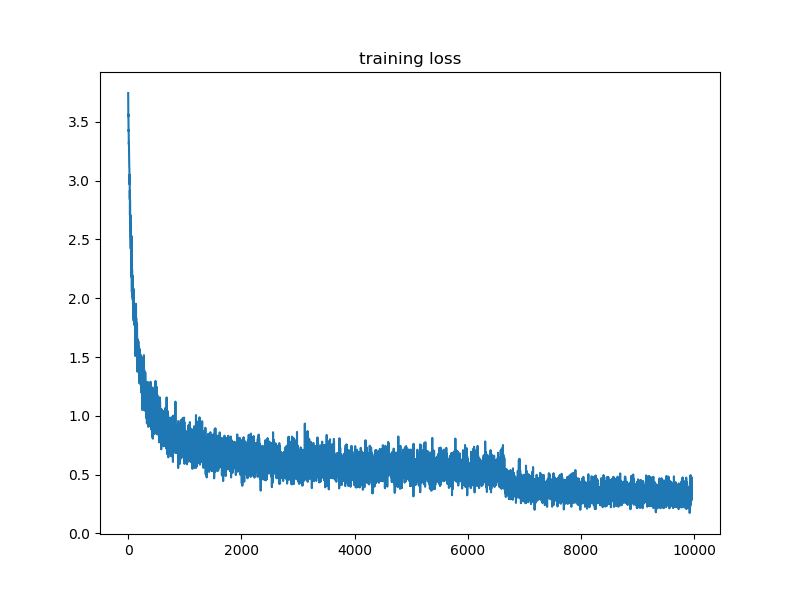

In [22]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")
plt.show()

In [19]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [23]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
    else:
        print("All examples in this dataset were correctly classified!")
        print("In this case, let's just look at the last data point")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

All examples in this dataset were correctly classified!
In this case, let's just look at the last data point
Data point #0. Expected: right. Predicted: right.
Data point #1. Expected: right. Predicted: nine.


In [21]:
# ### save model
# model_name = 'sample_classic_model_SPEECHCOMMANDS'
# save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'
# print('Saving trained model {} in {}'.format(model_name, save_path))

# # save model entirely
# torch.save(model, save_path+model_name+'_full.pth')

# # save model weights
# torch.save(model.state_dict(), save_path+model_name+'_state_dict.pth')



Saving trained model sample_classic_model_SPEECHCOMMANDS in ../Experiments/sample_SPEECHCOMMANDS_models/
